In [ ]:
# Input the dataset
import numpy as np
from sklearn.model_selection import train_test_split
import os
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
%cd /gdrive/'My Drive'


dataset_path = "cullpdb+profile_5926.npy"
print('the orginal dataset: ')
print(np.load(dataset_path).shape) # It is currently in numpy format as a (5926 proteins x 39900 features) matrix

# Reshape it to (5926 proteins x 700 amino acids x 57 features) matrix

sequence_len = 700  # The 700 amino-acids length cutoff was chosen to provide a good balance between efficiency and coverage as the majority of protein chains are shorter than 700 amino acids. 
                    #  Proteins are shorter than 700 amino acids are padded with all-zero features.
total_features = 57
amino_acid_residues = 21
num_classes = 8 
cnn_width = 15 # PSIPRED

def get_dataset(path):
    ds = np.load(path)
    ds = np.reshape(ds, (ds.shape[0], 700, 57))
    reshaped_dataset = np.zeros((ds.shape[0], ds.shape[1], amino_acid_residues + num_classes))
    reshaped_dataset[:, :, 0:amino_acid_residues] = ds[:, :, 35:56]  #[35,56): sequence profile
    reshaped_dataset[:, :, amino_acid_residues:] = ds[:, :, 22:30]  #[22,30): Secondary structure labels
    return reshaped_dataset

def get_data_labels(D):
    X = D[:, :, 0:21]   # (5926 proteins x 700 amino acids x 21 protein profiles)
    Y = D[:, :, 21:29]  # (5926 proteins x 700 amino acids x 8 labels)
    return X, Y

def resphape_labels(labels):
    Y = np.reshape(labels, (labels.shape[0]*labels.shape[1], labels.shape[2]))
    Y = Y[~np.all(Y == 0, axis=1)]
    return Y

def reshape_data(X):
    padding = np.zeros((X.shape[0], X.shape[2], int(cnn_width/2)))
    X = np.dstack((padding, np.swapaxes(X, 1, 2), padding))
    X = np.swapaxes(X, 1, 2)
    res = np.zeros((X.shape[0], X.shape[1] - cnn_width + 1, cnn_width, amino_acid_residues))
    for i in range(X.shape[1] - cnn_width + 1):
        res[:, i, :, :] = X[:, i:i+cnn_width, :]
    res = np.reshape(res, (X.shape[0]*(X.shape[1] - cnn_width + 1), cnn_width, amino_acid_residues))
    res = res[np.count_nonzero(res, axis=(1,2))>(int(cnn_width/2)*amino_acid_residues), :, :]
    return res

def split_dataset(Dataset, seed=None):
    np.random.seed(seed)
    np.random.shuffle(Dataset)
    train_split = int(Dataset.shape[0]*0.8)
    test_val_split = int(Dataset.shape[0]*0.1)
    Train = Dataset[0:train_split, :, :]
    Test = Dataset[train_split:train_split+test_val_split, :, :]
    Validation = Dataset[train_split+test_val_split:, :, :]
    return Train, Test, Validation

D = get_dataset(dataset_path)
print("reshaped the whole dataset:")
print(D.shape)

Train, Test, Validation = split_dataset(D)
X_te, Y_te = get_data_labels(Test)
X_tr, Y_tr = get_data_labels(Train)
X_v, Y_v = get_data_labels(Validation)
print("test dataset:")
print(X_te.shape, Y_te.shape)
print("train dataset:")
print(X_tr.shape, Y_tr.shape)
print("validation dataset:")
print(X_v.shape, Y_v.shape)

X_train = reshape_data(X_tr)
X_test = reshape_data(X_te)
X_validation = reshape_data(X_v)

Y_train = resphape_labels(Y_tr)
Y_test = resphape_labels(Y_te)
Y_validation = resphape_labels(Y_v)
print("train dataset input:")
print(X_train.shape, Y_train.shape)
print("validation dataset input:")
print(X_validation.shape, Y_validation.shape)
print("test dataset input:")
print(X_test.shape, Y_test.shape)

Mounted at /gdrive
/gdrive/My Drive
the orginal dataset: 
(5926, 39900)
reshaped the whole dataset:
(5926, 700, 29)
test dataset:
(592, 700, 21) (592, 700, 8)
train dataset:
(4740, 700, 21) (4740, 700, 8)
validation dataset:
(594, 700, 21) (594, 700, 8)
train dataset input:
(994420, 15, 21) (994420, 8)
validation dataset input:
(123115, 15, 21) (123115, 8)
test dataset input:
(127939, 15, 21) (127939, 8)


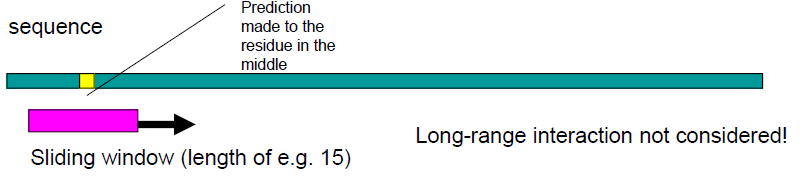

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from keras import optimizers, callbacks
from keras.regularizers import l2
import keras.backend as K
import tensorflow as tf

LR = 0.0012
drop_out = 0.38
batch_dim = 32
nn_epochs = 35

def CNN_model():
    m = Sequential()
    m.add(Conv1D(128, 5, padding='same', activation='relu', input_shape=(cnn_width, amino_acid_residues)))
    m.add(BatchNormalization())
    m.add(Dropout(drop_out))
    m.add(Conv1D(128, 3, padding='same', activation='relu'))
    m.add(BatchNormalization())
    m.add(Dropout(drop_out))
    m.add(Conv1D(64, 3, padding='same', activation='relu'))
    m.add(BatchNormalization())
    m.add(Dropout(drop_out))
    m.add(Flatten())
    m.add(Dense(128, activation='relu'))
    m.add(Dense(32, activation='relu'))
    m.add(Dense(num_classes, activation = 'softmax'))
    opt = optimizers.Adam(lr=LR)
    m.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'mae'])
    return m

build_model = CNN_model()
model_history = build_model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), epochs=nn_epochs, batch_size=batch_dim, shuffle=True)

Epoch 1/35
31073/31073 [==============================] - 329s 11ms/step - loss: 0.9413 - accuracy: 0.6611 - mae: 0.1112 - val_loss: 0.8441 - val_accuracy: 0.6937 - val_mae: 0.1022
Epoch 2/35
31073/31073 [==============================] - 335s 11ms/step - loss: 0.8843 - accuracy: 0.6809 - mae: 0.1054 - val_loss: 0.8281 - val_accuracy: 0.6979 - val_mae: 0.0973
Epoch 3/35
31073/31073 [==============================] - 323s 10ms/step - loss: 0.8654 - accuracy: 0.6875 - mae: 0.1034 - val_loss: 0.8177 - val_accuracy: 0.7024 - val_mae: 0.0961
Epoch 4/35
31073/31073 [==============================] - 328s 11ms/step - loss: 0.8563 - accuracy: 0.6906 - mae: 0.1024 - val_loss: 0.8069 - val_accuracy: 0.7078 - val_mae: 0.0977
Epoch 5/35
31073/31073 [==============================] - 342s 11ms/step - loss: 0.8499 - accuracy: 0.6928 - mae: 0.1017 - val_loss: 0.8094 - val_accuracy: 0.7063 - val_mae: 0.0949
Epoch 6/35
31073/31073 [==============================] - 363s 12ms/step - loss: 0.8456 - accur

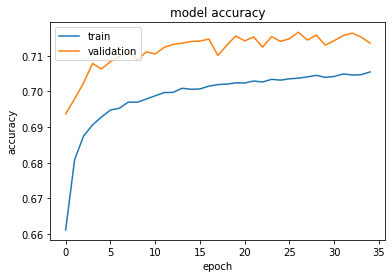

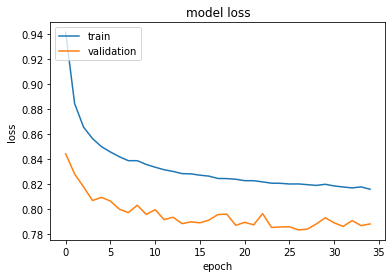

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
    
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
scores = build_model.evaluate(X_test, Y_test)
print("Loss: " + str(scores[0]) + ", Accuracy: " + str(scores[1]) + ", MAE: " + str(scores[2]))

3905/3905 [==============================] - 11s 3ms/step - loss: 0.7984 - accuracy: 0.7115 - mae: 0.0938
Loss: 0.7983564138412476, Accuracy: 0.7115472555160522, MAE: 0.09375844150781631
